In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

from qiskit.quantum_info import Statevector, random_statevector

from qiskit.visualization import plot_distribution, plot_bloch_multivector
from qiskit.visualization import array_to_latex

from qiskit_aer import AerSimulator

In [2]:
# Definición de funciones para implementar las diversas etapas del circuito de teletransportación cuántica con estado W para 1 qubit
def crear_estado_w(qc, a, b, c):
    # Crear un estado W en los qubits a, b y c
    qc.ry(2 * np.pi / 3, a)
    qc.cu(np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2, a, b)
    qc.cx(b, c)
    qc.cx(a, b)
    qc.x(a)

def circuito_de_alice_w(qc, q2send, beta):
    # Alice aplica operaciones en el qubit a enviar y el qubit de Bell
    qc.cx(q2send, beta)
    qc.h(q2send)

def medicion_de_alice_w(qc, a, b, c, crz, crx, cry):
    # Alice mide sus qubits y almacena los resultados en bits clásicos
    qc.barrier()
    qc.measure(a, crz)
    qc.measure(b, crx)
    qc.measure(c, cry)
    qc.barrier()

def circuito_de_bob_w(qc, beta, m1, m2, m3):
    # Bob usa los bits clásicos para aplicar compuertas de manera condicional
    with qc.if_test((m1, True)):
        qc.z(beta)
    with qc.if_test((m2, True)):
        qc.x(beta)
    with qc.if_test((m3, True)):
        qc.x(beta)

        
    
        
    


In [3]:
# Definición de registros de qubits de entrada
Q2teletransport = QuantumRegister(1, name='Qubit_C')  # Ahora contiene 1 qubit
QEntanglem_A = QuantumRegister(2, name='Qubit_A')  # Ahora contiene 4 qubit
QEntanglem_B = QuantumRegister(1, name='Qubit_B')  # Ahora contiene 1 qubit

# Definición de registros de 3 bits clásicos para medida
crz = ClassicalRegister(1, name='crz')
crx = ClassicalRegister(1, name='crx')
cry = ClassicalRegister(1, name='cry')

crbob = ClassicalRegister(1, name='crbob')  # Ahora contiene 1 bits clásicos

# Definición del circuito de teletransportación cuántica
teleport_cir = QuantumCircuit(QEntanglem_A, QEntanglem_B, Q2teletransport, crz, crx, cry, crbob)


<IPython.core.display.Latex object>

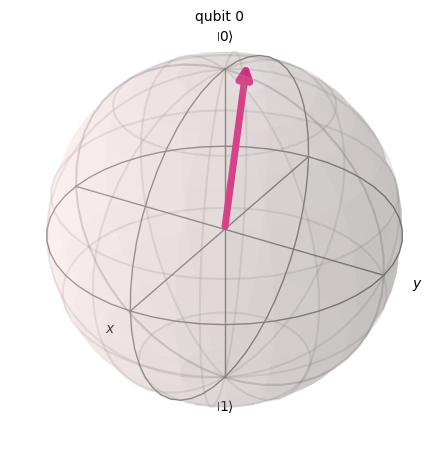

Las probabilidades del estado cuántico aleatorio son: [0.86639294 0.13360706]


In [4]:
# Definición de un estado cuántico aleatorio de entrada para ser teletransportado
qrandom1 = random_statevector(2)

# Mostrar el estado en notación de Dirac
display(array_to_latex(Statevector(qrandom1), prefix="\\ket{\\psi_1} = "))

# Visualización en la esfera de Bloch
fig1 = plot_bloch_multivector(Statevector(qrandom1))
plt.show()

# Mostrar las probabilidades del estado cuántico
print("Las probabilidades del estado cuántico aleatorio son:", Statevector(qrandom1).probabilities())


In [5]:
# Ensamblado del circuito completo de la Teletransportación Cuántica con estado W
init_gate = QuantumCircuit(1, name="Random Input") 
init_gate.initialize(qrandom1, 0)

teleport_cir.append(init_gate.to_instruction(), Q2teletransport)
teleport_cir.barrier()  # Uso de "barrier" (barrera) para separar las diversas etapas

# Crear el estado W en los qubits de entrelazamiento
crear_estado_w(teleport_cir, QEntanglem_A[0], QEntanglem_A[1], QEntanglem_B[0])
teleport_cir.barrier()

# Circuito de Alice
circuito_de_alice_w(teleport_cir, Q2teletransport[0], QEntanglem_A[1])

# Medición de Alice
medicion_de_alice_w(teleport_cir, Q2teletransport[0], QEntanglem_A[0], QEntanglem_A[1], crz, crx, cry)

# Circuito de Bob
circuito_de_bob_w(teleport_cir, QEntanglem_B[0], crz, crx, cry)


In [6]:
# Definición de simuladores requeridos
statevector_simulator = AerSimulator(method='statevector')
circuit_simulator = AerSimulator()

In [7]:
# Simulación del Vector de Estado a la salida del circuito
teleport_cir_statevector = teleport_cir.copy()
teleport_cir_statevector.save_statevector()

In [8]:
# Transpilación para posteriormente realizar la simulación del vector de estado resultante
circ_statevector = transpile(teleport_cir_statevector, statevector_simulator)

# Ejecución y obtención del statevector
result = statevector_simulator.run(circ_statevector).result()
statevector = result.get_statevector(circ_statevector)

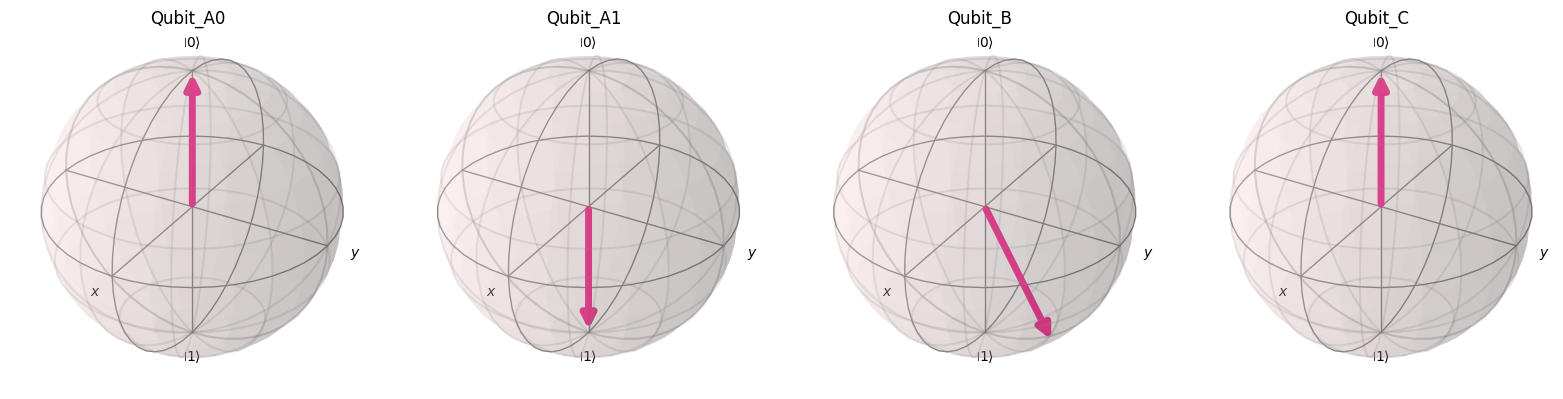

<IPython.core.display.Latex object>

Las probabilidades del estado cuántico aleatorio son: [0.         0.         0.13360706 0.         0.         0.
 0.86639294 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [9]:
fig = plot_bloch_multivector(statevector)

custom_labels = ['Qubit_A0', 'Qubit_A1', 'Qubit_B', 'Qubit_C']
# Personalizar los títulos de los ejes
for ax, label in zip(fig.axes, custom_labels):
    ax.set_title(label, pad=28)
plt.show()

display(array_to_latex(Statevector(statevector), prefix="\\ket{Salida_{statevector}} = "))

print("Las probabilidades del estado cuántico aleatorio son:", Statevector(statevector).probabilities())

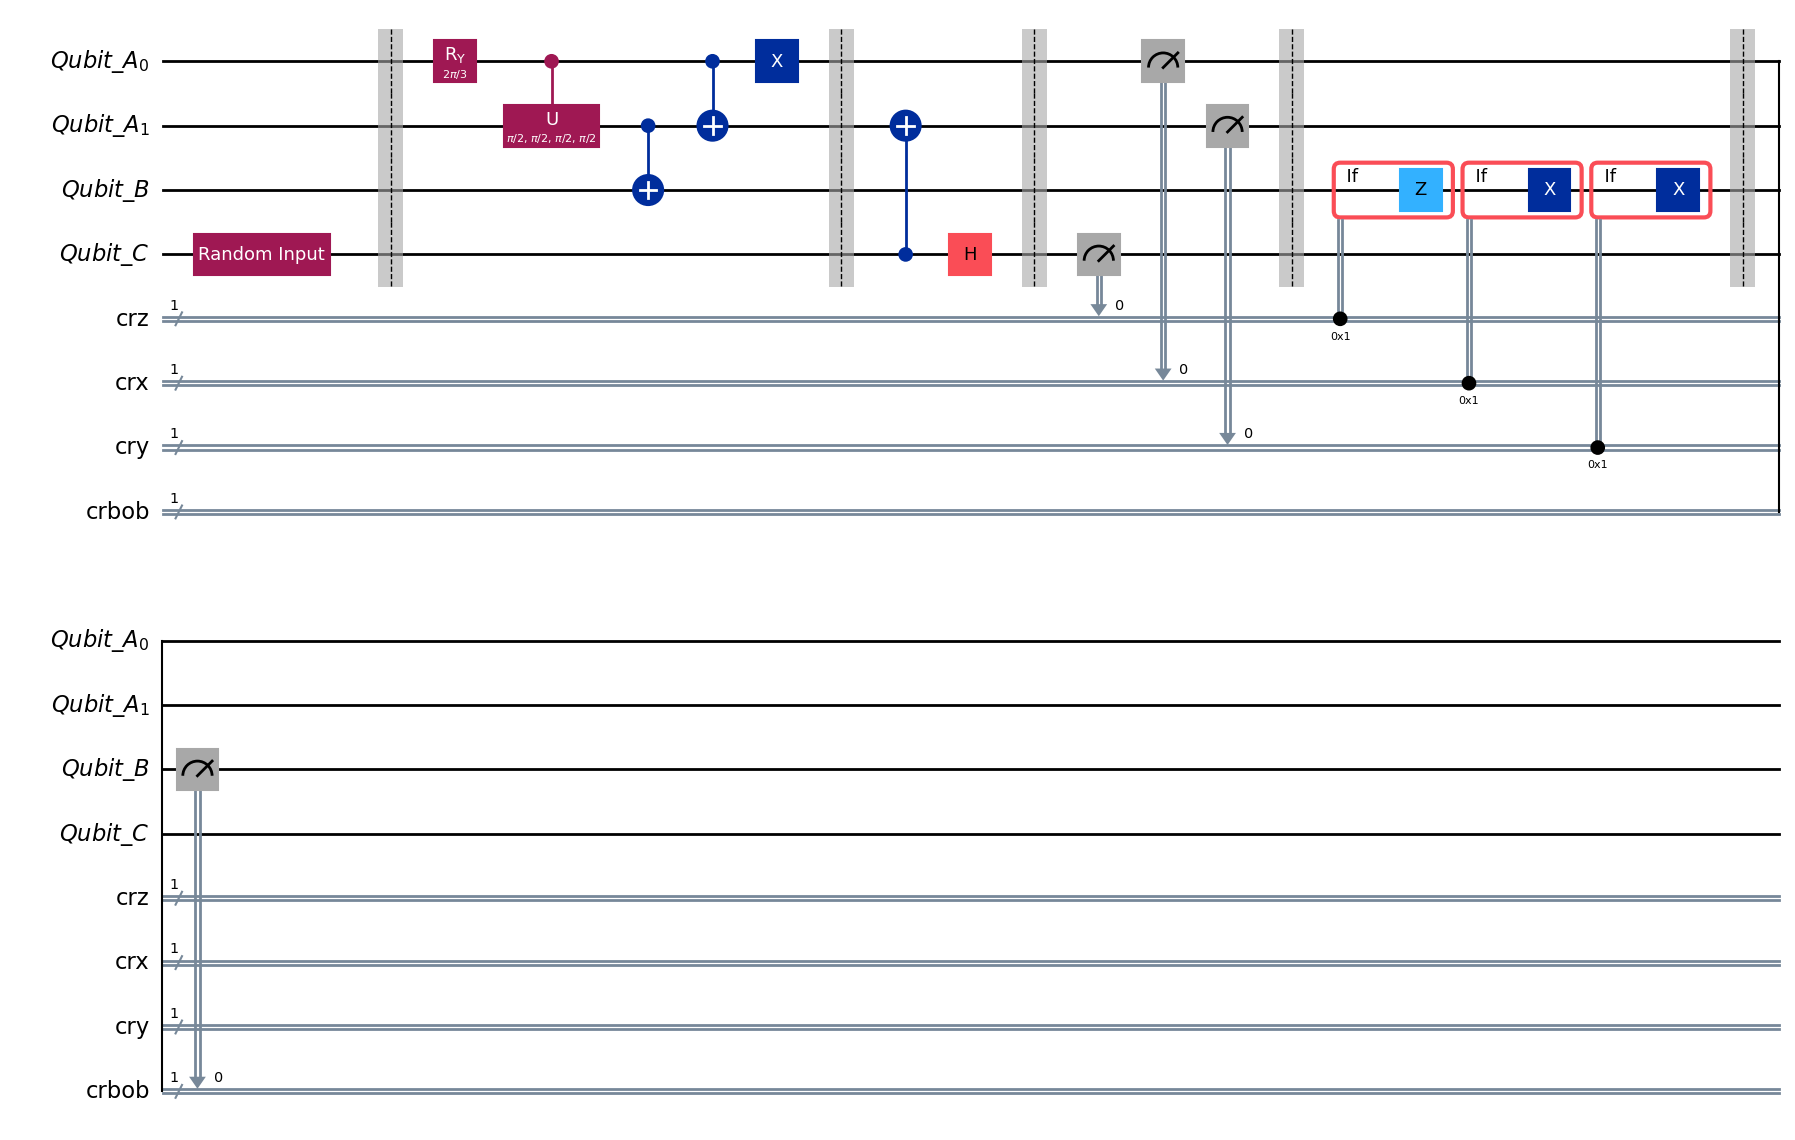

In [10]:
teleport_cir.barrier() # Uso de "barrier" (barrera) para separar las diversas etapas


# Medir QEntanglem_B en el registro clásico corregido
teleport_cir.measure(QEntanglem_B, crbob)

# Gráfica del circuito completo de Teletransportación CuánticaQEntanglem_B
teleport_cir.draw('mpl')
plt.show()

<Figure size 2400x600 with 0 Axes>

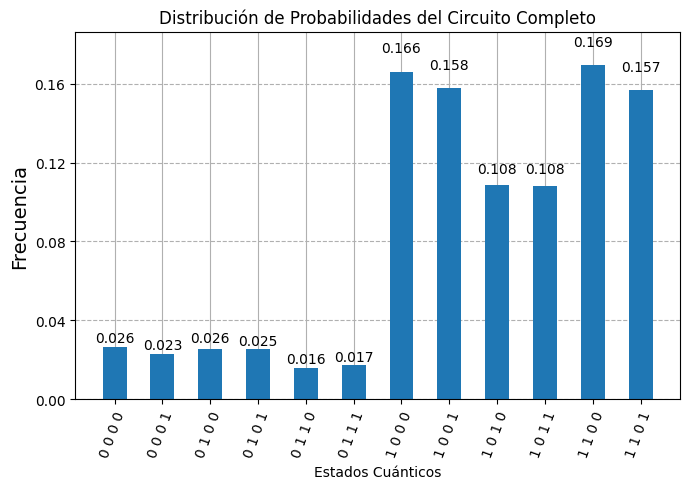

In [11]:
# Simulación del circuito completo
shots = 8192

# Ejecutar la simulación del circuito descompuesto
teleport_result = circuit_simulator.run(
    teleport_cir.decompose(reps=1), 
    shots=shots
).result()

# Obtener los resultados de las cuentas
data = teleport_result.get_counts(teleport_cir)

# Visualizar la distribución de probabilidades
#Hacer mas anchura la grafica
plt.figure(figsize=(24, 6)) 
plot_distribution(data)
plt.title("Distribución de Probabilidades del Circuito Completo")
plt.xlabel("Estados Cuánticos")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
print ("Resultados de la Teletransportación Cuántica con Estado W:")
# Mostrar los resultados de la teletransportación cuántica
for key, value in data.items():
    print(f"Estado: {key}, Frecuencia: {value}")

Resultados de la Teletransportación Cuántica con Estado W:
Estado: 0 0 0 1, Frecuencia: 188
Estado: 0 0 0 0, Frecuencia: 216
Estado: 0 1 0 0, Frecuencia: 209
Estado: 0 1 0 1, Frecuencia: 208
Estado: 0 1 1 1, Frecuencia: 142
Estado: 1 0 1 1, Frecuencia: 885
Estado: 1 0 1 0, Frecuencia: 888
Estado: 1 1 0 0, Frecuencia: 1387
Estado: 1 0 0 0, Frecuencia: 1360
Estado: 1 0 0 1, Frecuencia: 1293
Estado: 1 1 0 1, Frecuencia: 1284
Estado: 0 1 1 0, Frecuencia: 132


In [13]:
# Con las siguientes instrucciones se pueden extraer de manera más clara los qubits de Alice para el estado W con 1 qubit.
alice = {}
alice['000'] = data['0 0 0 0'] + + data['1 0 0 0']
alice['001'] = data['0 0 0 1'] + data['1 0 0 1']
alice['010'] = data['0 0 1 0'] + data['1 0 1 0']
alice['011'] = data['0 0 1 1'] + data['1 0 1 1']
alice['100'] = data['0 1 0 0']
alice['101'] = data['0 1 0 1']



plot_distribution(alice)
plt.title("Distribución de Probabilidades de los Qubits de Alice")
plt.xlabel("Estados Cuánticos de Alice")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: '0 0 1 0'

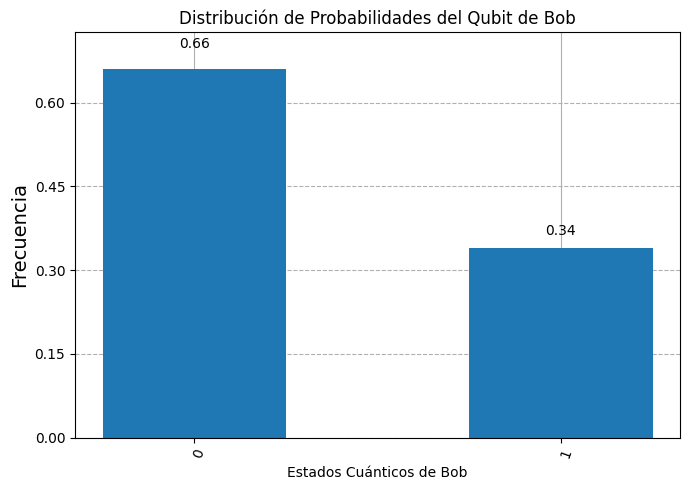

In [ ]:
# Y con las siguientes instrucciones se puede extraer de manera más clara el qubit de Bob.
bob = {}
bob['0'] = data.get('0 0 0 0', 0) + data.get('0 0 1 0', 0) + data.get('1 0 0 0', 0) + data.get('1 0 1 0', 0)
bob['1'] = data.get('0 1 0 0', 0) + data.get('0 1 1 0', 0) + data.get('1 1 0 0', 0) + data.get('1 1 1 0', 0)

plot_distribution(bob)
plt.title("Distribución de Probabilidades del Qubit de Bob")
plt.xlabel("Estados Cuánticos de Bob")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from qiskit import __version__ as qiskit_version
from qiskit_aer import __version__ as aer_version
from platform import python_version

print('Qiskit Version:', qiskit_version)
print('Qiskit_Aer Version:', aer_version)
print('Python Version:', python_version())
print('2025 ©')

Qiskit Version: 2.0.0
Qiskit_Aer Version: 0.17.0
Python Version: 3.12.1
2025 ©
